# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
%autosave 180
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

Autosaving every 180 seconds


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

Mean # article : 8.930846930846931
Quantile 0.25 , 0.5, 0.75:  1.0 3.0 9.0


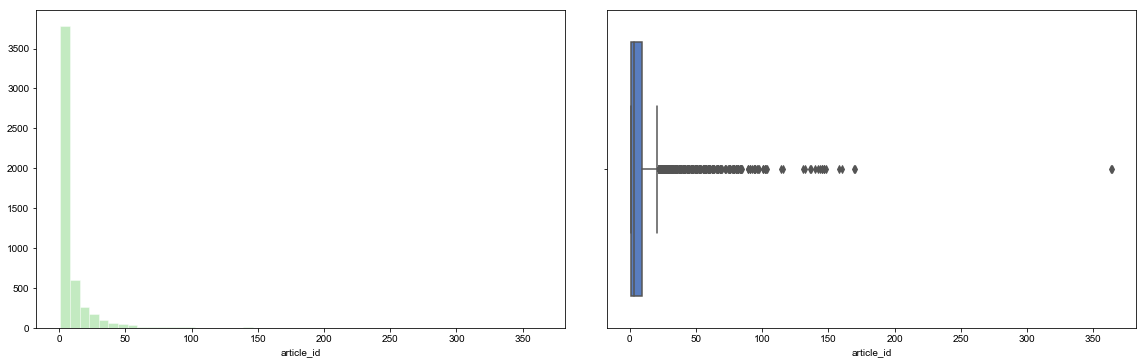

In [3]:
# make a groupby instance and count how many articles were read by each user
email_grouped_df = df.groupby('email')
num_article_email = email_grouped_df['article_id'].count()
print("Mean # article :",num_article_email.mean())
print("Quantile 0.25 , 0.5, 0.75: " , num_article_email.quantile(0.25), num_article_email.quantile(0.5), num_article_email.quantile(0.75))
# Draw histogram and boxplot using seaborn
f, axes = plt.subplots(1, 2, figsize=(16,5))
f.tight_layout()
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")
sns.distplot(num_article_email, rug=False, kde=False,  norm_hist=False, color='g', ax=axes[0])
sns.boxplot(num_article_email, ax=axes[1])

In [4]:
# Fill in the median and maximum number of user_article interactios below
median_val =   num_article_email.median()
max_views_by_user = num_article_email.max()
print("50% of individuals interact with {} number of articles or fewer.".format(median_val)) 
print("The maximum number of user-article interactions by any 1 user is{}:".format(max_views_by_user))
# 50% of individuals interact with ____ number of articles or fewer.
# The maximum number of user-article interactions by any 1 user is ______.

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is364:


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Find and explore duplicate articles
df_content.head()
check_dupl_df_1 = df_content[df_content.duplicated(['article_id'])]
check_dupl_df_1

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [6]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)
check_dupl_df_1 = df_content[df_content.duplicated(['article_id'])]
check_dupl_df_1

,doc_body,doc_description,doc_full_name,doc_status,article_id


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:
df_content.head(3)
df.head(3)
print(len(df.article_id.unique()))
print(len(df_content.article_id.unique()))
print(len(df.email.unique()))
print(df.shape[0])
df[df.email.isna() == True]
df_email_na_dropped = df.dropna(subset=['email'])
len(df_email_na_dropped.email.unique())

714
1051
5149
45993


5148

In [8]:
unique_articles = len(df.article_id.unique()) # The number of unique articles that have at least one interaction
total_articles = len(df_content.article_id.unique()) # The number of unique articles on the IBM platform
unique_users = len(df_email_na_dropped.email.unique()) # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
# df_content.head(3)
article_id_grouped_df = df.groupby('article_id')
print(article_id_grouped_df['email'].count().sort_values(ascending=False).index[0])
print(article_id_grouped_df['email'].count().sort_values(ascending=False).values[0])

1429.0
937


In [10]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [11]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [12]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [13]:
df.head(2)
article_id_grouped_df = df.groupby(['title','article_id'])
article_id_grouped_df['user_id'].count().sort_values(ascending=False)

# article_id_grouped_df = df.groupby(['article_id','title'])
# print(article_id_grouped_df['user_id'].count().sort_values(ascending=False))
# article_id_grouped_df['user_id'].count().sort_values(ascending=False).iloc[0:10].index

title                                                                               article_id
use deep learning for image classification                                          1429.0        937
insights from new york car accident reports                                         1330.0        927
visualize car data with brunel                                                      1431.0        671
use xgboost, scikit-learn & ibm watson machine learning apis                        1427.0        643
predicting churn with the spss random tree algorithm                                1364.0        627
healthcare python streaming application demo                                        1314.0        614
finding optimal locations of new store using decision optimization                  1293.0        572
apache spark lab, part 1: basic concepts                                            1170.0        565
analyze energy consumption in buildings                                             1162.

In [14]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_id_grouped_df = df.groupby(['title'])
    top_articles = article_id_grouped_df['user_id'].count().sort_values(ascending=False).iloc[:n].index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_id_grouped_df = df.groupby(['article_id'])
    top_articles_ids = article_id_grouped_df['user_id'].count().sort_values(ascending=False).iloc[:n].index.tolist()

    return top_articles_ids # Return the top article ids

In [15]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [16]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [17]:
df.head(4)
# user_items.groupby(['user_id', 'article_id'])['rating'].max().unstack()
df_tmp = df.groupby('user_id')['article_id'].value_counts().unstack()
df_tmp[df_tmp.isna() == False] = 1
df_tmp.head(5)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby('user_id')['article_id'].value_counts().unstack()
    user_item[user_item.isna() == False] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [19]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [20]:
user_item.head(9)
user_item_tmp = user_item.copy()
user_item_tmp[user_item_tmp.isna() == True] = 0 # 1. Make Nan to 0
row = user_item_tmp.loc[3] # 1. Select a row
print(row.shape)
print(user_item_tmp.T.shape)
# 2. Execute dot product
result_dot = row@user_item_tmp.T
# 3. Get a list of results
result_dot = result_dot.sort_values(ascending=False)
result_dot = result_dot.drop(labels = [3])
result_dot = result_dot.index.tolist()


# result_dot.pop(0)
# print(result_dot[0:10])
# 4. row dot product each rows in the dataframe

(714,)
(714, 5149)


In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_item_tmp = user_item.copy()
    user_item_tmp[user_item_tmp.isna() == True] = 0 # 1. Make Nan to 0
    row = user_item_tmp.loc[user_id] # 2. Select a row
    result_dot = row@user_item_tmp.T # 3. Dot product of each of row of the matrix 
    result_dot.drop(labels = [user_id], inplace=True) # remove the own user's id
    most_similar_users = result_dot.sort_values(ascending=False).index.tolist()  # sort by similarity # create list of just the ids
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))


The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [23]:
df.head()
# # For def get_article_names(article_ids, df=df):
# tmp_list = [1430,1314,1276]
# empty_list = []
# for i in tmp_list:
#     title = df[df['article_id'] == i]['title'].unique()[0]
#     empty_list.append(title)
# print(empty_list)


# # For def get_user_articles(user_id, user_item=user_item):
# user_item.head()
# article_ids = user_item.loc[1][user_item.loc[1] ==1].index.tolist()
# article_ids

# For def user_user_recs(user_id, m=10):
# rec_list = []
# counter = 0

# article_ids, article_names = get_user_articles(4) # Get seen article ids and names
# seen_ids_set = set(article_ids)
# print("a set of article ids seen by a selected person:", seen_ids_set)
# print("**"*20)
# find_similar_users(): find similar users to the user
# most_similar_users = find_similar_users(4)[0:5]
# for sim_user in most_similar_users:
#     if counter < 10: 
#         sim_article_ids, sim_article_names = get_user_articles(sim_user) 
#         sim_seen_ids_set = set(sim_article_ids)
# #         sim_seen_arti_name_set = set(sim_article_names)
#         print("a set of article ids seen by a similar person:", sim_seen_ids_set)
#         print("**"*20)
#         unseen_ids_set = sim_seen_ids_set.difference(seen_ids_set)
#         print("a set of article ids unseen by the selected person", unseen_ids_set)
#     #     print(sim_user_dict[230])


#         for i in unseen_ids_set: # Unseen articles
#             if counter < 10: 
#                 rec_list.append(i)
#                 counter += 1

# print(rec_list)
# print(len(rec_list))



,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    article_ids = list(map(float, article_ids))
    for i in article_ids:
        
        try:
            title = df[df['article_id'] == i]['title'].unique()[0]
        except IndexError:
            title ="None"
            
        article_names.append(title)
    return article_names # Return the article names associated with list of article ids

# try:
#     myVar
# except IndexError:
#     myVar = "None"

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id][user_item.loc[user_id] ==1].index.tolist()
    article_ids = list(map(str, article_ids))
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    counter = 0
    # Get seen article ids and names from selected user id
    article_ids, article_names = get_user_articles(user_id)
    # Make set to find unseen articles
    seen_ids_set = set(article_ids)
    # Find five similar users of the selected user
    most_similar_users = find_similar_users(user_id)[0:5]
    
    # Make recommendation list
    for sim_user in most_similar_users:
         if counter < m: 
            # Get seen article ids and names from similar users
            sim_article_ids, sim_article_names = get_user_articles(sim_user) 
            # Make dict (key: article_ids, value:article_names)
            sim_user_dict = dict(zip(sim_article_ids, sim_article_names)) 
            # Make set to find unseen articles
            sim_seen_ids_set = set(sim_article_ids)
            # Create set of unseen articles_ids
            unseen_ids_set = sim_seen_ids_set.difference(seen_ids_set)

            for i in unseen_ids_set: 
                if counter < m: 
                    recs.append(i)
                    counter += 1
    
    return recs # return your recommendations for this user_id    

In [25]:
get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

['using deep learning to reconstruct high-resolution audio',
 'build a python app on the streaming analytics service',
 'gosales transactions for naive bayes model',
 'healthcare python streaming application demo',
 'use r dataframes & ibm watson natural language understanding',
 'use xgboost, scikit-learn & ibm watson machine learning apis']

In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['apache spark lab, part 2: querying data',
 'using github for project control in dsx',
 '56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object',
 'challenges in deep learning',
 'use sql with data in hadoop python',
 'movie recommender system with spark machine learning',
 'process events from the watson iot platform in a streams python application',
 'awesome deep learning papers',
 'ml optimization using cognitive assistant',
 'the unit commitment problem']

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [30]:
# def get_top_articles(n, df=df):
#     '''
#     INPUT:
#     n - (int) the number of top articles to return
#     df - (pandas dataframe) df as defined at the top of the notebook 
    
#     OUTPUT:
#     top_articles - (list) A list of the top 'n' article titles 
    
#     '''

df.head()

df.groupby("user_id")['article_id'].count().sort_values(ascending=False)
most_similar_users = find_similar_users(user_id)[0:10]
neighbors_df = pd.DataFrame()
neighbors_df['neighbor_id'] = most_similar_users
neighbors_df
row = user_item_tmp.loc[user_id] # 2. Select a row
result_dot = row@user_item_tmp.T # 3. Dot product of each of row of the matrix 
result_dot.drop(labels = [user_id], inplace=True) # remove the own user's id
similarity = result_dot.sort_values(ascending=False).values.tolist()[0:10] 
neighbors_df['similarity'] = similarity
neighbors_df
num_interactions = []
for i in neighbors_df['neighbor_id']:
    counted_interaction = df.groupby("user_id")['article_id'].count().loc[i]
    num_interactions.append(counted_interaction)
neighbors_df['num_interactions'] = num_interactions
neighbors_df
neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=True)
        
# df.groupby("user_id")['article_id'].count().sort_values(ascending=False).loc[3933]
# most_similar_users = result_dot.sort_values(ascending=False).index.tolist()  

In [31]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Make neighbor_id column
    df_user_id_grouped =df.groupby("user_id")
    df_user_id_grouped['article_id'].count().sort_values(ascending=False)
    most_similar_users = find_similar_users(user_id)[0:10]
    neighbors_df = pd.DataFrame()
    neighbors_df['neighbor_id'] = most_similar_users
    
    # make similarity column
    row = user_item_tmp.loc[user_id] # Select a row
    result_dot = row@user_item_tmp.T # Dot product of each of row of the matrix 
    result_dot.drop(labels = [user_id], inplace=True) # remove the own user's id
    similarity = result_dot.sort_values(ascending=False).values.tolist()[0:10] 
    neighbors_df['similarity'] = similarity
    
    # Make num_interactions column
    num_interactions = []
    for i in neighbors_df['neighbor_id']:
        counted_interaction = df_user_id_grouped['article_id'].count().loc[i]
        num_interactions.append(counted_interaction)
    neighbors_df['num_interactions'] = num_interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    rec_names =[]
    counter = 0
    # Get seen article ids and names from selected user id
    article_ids, article_names = get_user_articles(user_id)
    # Make set to find unseen articles
    seen_ids_set = set(article_ids)
    # Find five similar users of the selected user
    neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item)
    similar_users_list = neighbors_df['neighbor_id'] # Get neighbor_df

    # Make recommendation list
    for sim_user in similar_users_list:
         if counter < m: 
            # Get seen article ids and names from similar users
            sim_article_ids, sim_article_names = get_user_articles(sim_user) 
            # Make dict (key: article_ids, value:article_names)
            sim_user_dict = dict(zip(sim_article_ids, sim_article_names)) 
            # Make set to find unseen articles
            sim_seen_ids_set = set(sim_article_ids)
            # Create set of unseen articles_ids
            unseen_ids_set = sim_seen_ids_set.difference(seen_ids_set)
#             unseen_article_names_set = sim_seen_article_names_set.difference(seen_article_names_set)

            for i in unseen_ids_set: 
                if counter < m: 
                    recs.append(i)
                    rec_names.append(sim_user_dict[i])
                    counter += 1
    
    
    return recs, rec_names

In [33]:
user_id = 20
m = 10
# tmp.neighbor_id.values

recs = []
rec_names =[]
counter = 0
# Get seen article ids and names from selected user id
article_ids, article_names = get_user_articles(user_id)
# Make set to find unseen articles
seen_ids_set = set(article_ids)
# seen_article_names_set = set(article_names)
# Find five similar users of the selected user
neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item)
similar_users_list = neighbors_df['neighbor_id'] # Get neighbor_df

# Make recommendation list
for sim_user in similar_users_list:
     if counter < m: 
        # Get seen article ids and names from similar users
        sim_article_ids, sim_article_names = get_user_articles(sim_user) 
        # Make dict (key: article_ids, value:article_names)
        sim_user_dict = dict(zip(sim_article_ids, sim_article_names)) 
        # Make set to find unseen articles
        sim_seen_ids_set = set(sim_article_ids)
#         sim_seen_article_names_set = set(sim_article_ids)
        # Create set of unseen articles_ids
        unseen_ids_set = sim_seen_ids_set.difference(seen_ids_set)
#         unseen_article_names_set = sim_seen_article_names_set.difference(seen_article_names_set)

        for i in unseen_ids_set: 
            if counter < m: 
                recs.append(i)
                rec_names.append(sim_user_dict[i])
                counter += 1
                
print(recs)
print(rec_names)


['253.0', '1186.0', '1330.0', '315.0', '43.0', '880.0', '468.0', '1338.0', '464.0', '237.0']
['56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object', 'connect to db2 warehouse on cloud and db2 using scala', 'insights from new york car accident reports', 'neurally embedded emojis', 'deep learning with tensorflow course by big data university', 'probabilistic graphical models tutorial\u200a—\u200apart 1 – stats and bots', 'what is hadoop?', 'ml optimization using cognitive assistant', 'use ibm data science experience to detect time series anomalies', 'deep learning with data science experience']


In [34]:
df_content[df_content.article_id == 607]

,doc_body,doc_description,doc_full_name,doc_status,article_id
608,Stats and Bots Follow Sign in / Sign up * Home...,"Today, many companies use big data to make sup...",Recommendation System Algorithms – Stats and Bots,Live,607


In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['253.0', '1186.0', '1330.0', '315.0', '43.0', '880.0', '468.0', '1338.0', '464.0', '237.0']

The top 10 recommendations for user 20 are the following article names:
['56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object', 'connect to db2 warehouse on cloud and db2 using scala', 'insights from new york car accident reports', 'neurally embedded emojis', 'deep learning with tensorflow course by big data university', 'probabilistic graphical models tutorial\u200a—\u200apart 1 – stats and bots', 'what is hadoop?', 'ml optimization using cognitive assistant', 'use ibm data science experience to detect time series anomalies', 'deep learning with data science experience']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [36]:
### Tests with a dictionary of results
neighbor_df_1 = get_top_sorted_users(1, df=df, user_item=user_item)
neighbor_df_131 = get_top_sorted_users(131, df=df, user_item=user_item)

user1_most_sim = neighbor_df_1.neighbor_id[0].item()# Find the user that is most similar to user 1 
user131_10th_sim = neighbor_df_131.neighbor_id[9].item() # Find the 10th most similar user to user 131

In [37]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Rank based recommendation is suitable for a new user because it only depends on the popularity of an article. As no interaction with articles has been made, user-user based collaborative filtering is not possible for a new user. If we know the preference of a new user, for example, a few key words are given by a new user, we could use the information to make a recommendation. In sum, content based and rank based recommendations are better methods for new users.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [38]:
new_user = '0.0'
# top_10 = get_top_articles(10)
top_10 = get_top_article_ids(10, df=df)
# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
top_10 = list(map(str, top_10))
new_user_recs = top_10# Your recommendations here



In [39]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [40]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dalpengholic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dalpengholic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dalpengholic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
corpus = df_content['doc_description']
df_content[df_content['doc_description'].isna() == True]
df_content['doc_description'].fillna(df_content['doc_full_name'], inplace=True)
df_content[df_content['doc_description'].isna() == True]

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
# Text Processing, Feature Extraction
def tokenize(text):
    '''
    Function splits text into separate words and gets a word lowercased and removes whitespaces at the ends of a word. 
    The funtions also cleans irrelevant stopwords.
    Input:
    1. text: text message
    Output:
    1. Clean_tokens : list of tokenized clean words
    '''
    # Get rid of other sepcial characters   
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # Tokenize
    tokens = word_tokenize(text)
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok, pos='v').lower().strip()
        clean_tokens.append(clean_tok)
    
    # Remove stop words    
    stopwords = nltk.corpus.stopwords.words('english')
    clean_tokens = [token for token in clean_tokens if token not in stopwords]
    
    return clean_tokens

vect = TfidfVectorizer(tokenizer=tokenize)
# get counts of each token (word) in text data
X = vect.fit_transform(corpus)
X = X.toarray()
X.shape
df_content


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


In [42]:
tfidf_feature_name = vect.get_feature_names()
print(len(tfidf_feature_name))
# comping cosine similarity matrix using linear_kernal of sklearn
cosine_similarity = linear_kernel(X, X) # Matrix after dot product of each TfidfVector
cosine_similarity.shape

3361


(1051, 1051)

In [53]:
article_id = 1050
print(cosine_similarity[article_id])
df_similarity = pd.DataFrame(cosine_similarity[article_id], columns=['similarity'])
df_similarity_modified = df_similarity.drop(article_id)
recs = df_similarity_modified.similarity.sort_values(ascending=False).index[0:10].tolist()
rec_names = []
df_content.head()
for i in recs:
    name = df_content[df_content['article_id'] == i]['doc_full_name'].values[0]
    rec_names.append(name)
    
df_content.tail()
# rec_names = get_article_names(recs, df=df)
# rec_names

# # exist in df_content, not exist in df. 
# df[df.article_id ==249].head()
# df_article_set = set(df.article_id.unique())
# df_article_set
# df_content_article_set = set(df_content.article_id.unique())
# df_content_article_set
# article_diffset = df_content_article_set.difference(df_article_set)
# no_article_list = list(article_diffset)
# no_article_list

# df_content.loc([no_article_list])
# # df.head()
# # df_content.head()

# df_add = pd.DataFrame(columns=['article_id','title',"user_id"])
# for i in no_article_list:
#     name = df_content[df_content.article == i]['doc_full_name'].values
#     df_add['title'] = 
    



[0.01207874 0.         0.         ... 0.         0.01035816 1.        ]


,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


In [51]:
def make_content_recs(article_id, df_content, df, m=10):
    '''
    INPUT:
    article_id = (int) a article id in df_content
    m - (int) the number of recommendations you want for the user
    df_content -  (pandas dataframe) df_content as defined at the top of the notebook 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''
    corpus = df_content['doc_description']
    df_content['doc_description'].fillna(df_content['doc_full_name'], inplace=True)

    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    # Text Processing, Feature Extraction
    def tokenize(text):
        '''
        Function splits text into separate words and gets a word lowercased and removes whitespaces at the ends of a word. 
        The funtions also cleans irrelevant stopwords.
        Input:
        1. text: text message
        Output:
        1. Clean_tokens : list of tokenized clean words
        '''
        # Get rid of other sepcial characters   
        text = re.sub(r"[^a-zA-Z0-9]", " ", text)
        # Tokenize
        tokens = word_tokenize(text)
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        clean_tokens = []
        for tok in tokens:
            clean_tok = lemmatizer.lemmatize(tok, pos='v').lower().strip()
            clean_tokens.append(clean_tok)

        # Remove stop words    
        stopwords = nltk.corpus.stopwords.words('english')
        clean_tokens = [token for token in clean_tokens if token not in stopwords]

        return clean_tokens
    
    vect = TfidfVectorizer(tokenizer=tokenize)
    # get counts of each token (word) in text data
    X = vect.fit_transform(corpus)
    X = X.toarray()
    cosine_similarity = linear_kernel(X, X)
    df_similarity = pd.DataFrame(cosine_similarity[article_id], columns=['similarity'])
    df_similarity_modified = df_similarity.drop(article_id)
    recs = df_similarity_modified.similarity.sort_values(ascending=False).index[0:10].tolist()
    rec_names = []

    for i in recs:
        name = df_content[df_content['article_id'] == i]['doc_full_name'].values[0]
        rec_names.append(name)
    
    return recs, rec_names
#      INPUT:
#     user_id - (int) a user id
#     m - (int) the number of recommendations you want for the user
    
#     OUTPUT:
#     recs - (list) a list of recommendations for the user
    
#     Description:
#     Loops through the users based on closeness to the input user_id
#     For each user - finds articles the user hasn't seen before and provides them as recs
#     Does this until m recommendations are found
    

In [55]:
recs, rec_names = make_content_recs(0, df_content, df, m=10)
print(recs)
print("**"*30)
print(rec_names)


[730, 194, 53, 470, 1005, 980, 423, 266, 681, 670]
************************************************************
['Developing for the IBM Streaming Analytics service', 'Data science for real-time streaming analytics', 'Introducing Streams Designer', 'What’s new in the Streaming Analytics service on Bluemix', 'Real-time Sentiment Analysis of Twitter Hashtags with Spark', 'logshare', 'Web application state, à la Dogfight (1983) – IBM Watson Data Lab', 'Developing IBM Streams applications with the Python API (Version 1.6)', 'Real-Time Sentiment Analysis of Twitter Hashtags with Spark (+ PixieDust)', 'Calculate moving averages on real time data with Streams Designer']


In [57]:

df[df.article_id == 1427].head()

,article_id,title,user_id
42,1427.0,"use xgboost, scikit-learn & ibm watson machine...",31
53,1427.0,"use xgboost, scikit-learn & ibm watson machine...",38
60,1427.0,"use xgboost, scikit-learn & ibm watson machine...",6
61,1427.0,"use xgboost, scikit-learn & ibm watson machine...",43
68,1427.0,"use xgboost, scikit-learn & ibm watson machine...",46


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

Before making my content-based recommendation system, I read an article [here](https://towardsdatascience.com/introduction-to-two-approaches-of-content-based-recommendation-system-fc797460c18c) to grap idea how to build it. After reading it, I selected TF-IDF (Term Frequency - Inverse Document Frequency) method to make keywords to be TF-IDF Vectors. Then I used cosine similarity to find similar articles to a given article. This system could perform well to a user who has only one interaction with an ariticle. 

In my opinion, this system needs to be improved in three cases. The first case is for a brand new user having no interaction. In this case, the system could rely on `rank based recommendation system using` using `get_top_articles(n, df=df)` and `get_top_article_ids(n, df=df)`. The second case is a user who have interaction with an article but no information of the article in df_content like the scenario that a user having interaction with '1427' of article_id given below. In this case, `user_item` matrix could be used to find users who read the article. Then the order of the users needs to be sorted by the number of interaction. The top user is passed in `get_user_articles(user_id=top user, user_item=user_item)` to get `article_ids` and `article_names`.  Top 10 articles will be given by the order of the articles in `rank based recommendation system`.

The last case is the opposite of the previous case that a user having one interaction and there is a information in df_content. In this case, `content based recommendation` could be excuted using `make_content_recs(article_id, df_content, df, m=10)`.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [63]:
df.head()
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [105]:
user_item[user_item[1427.0] == 1].index # 1427 read user_id list
check_df_1 = pd.DataFrame(columns=['user_id', 'num_interactions'])
check_df_1['user_id'] = user_item[user_item[1427.0] == 1].index
num_interactions = []
for i in check_df_1['user_id']:
    df_user_id_grouped =df.groupby("user_id")
    counted_interaction = df_user_id_grouped['article_id'].count().loc[i]
    num_interactions.append(counted_interaction)
check_df_1['num_interactions'] = num_interactions
check_df_1 = check_df_1.sort_values(by=['num_interactions'], ascending=False)
top_user = check_df_1.iloc[0]['user_id']

article_ids, article_names= get_user_articles(user_id=top_user, user_item=user_item)
article_ids = list(map(float, article_ids))
print(article_ids)

article_id_grouped_df = df.groupby(['article_id'])
top_article_id_list = article_id_grouped_df['user_id'].count().sort_values(ascending=False).index.tolist()

rec = []
rec_names = []
m = 10
for i in top_article_id_list:
    if len(rec) < m:
        if i in article_ids:
            rec.append(i)
            rec_names.append(df[df['article_id']==i]['title'].unique()[0])
        else:
            pass
        
print(rec)
print(rec_names)
    

[2.0, 12.0, 14.0, 16.0, 26.0, 28.0, 29.0, 33.0, 43.0, 50.0, 74.0, 76.0, 108.0, 109.0, 120.0, 124.0, 131.0, 164.0, 193.0, 194.0, 210.0, 213.0, 221.0, 223.0, 236.0, 237.0, 241.0, 252.0, 253.0, 283.0, 295.0, 299.0, 302.0, 316.0, 336.0, 337.0, 339.0, 348.0, 359.0, 362.0, 367.0, 409.0, 422.0, 444.0, 477.0, 482.0, 510.0, 517.0, 524.0, 617.0, 634.0, 641.0, 656.0, 658.0, 665.0, 682.0, 693.0, 720.0, 721.0, 729.0, 744.0, 761.0, 800.0, 812.0, 821.0, 825.0, 833.0, 843.0, 887.0, 910.0, 939.0, 943.0, 952.0, 957.0, 967.0, 969.0, 973.0, 981.0, 996.0, 1000.0, 1014.0, 1025.0, 1051.0, 1052.0, 1101.0, 1148.0, 1159.0, 1160.0, 1162.0, 1163.0, 1164.0, 1165.0, 1166.0, 1170.0, 1171.0, 1172.0, 1176.0, 1181.0, 1185.0, 1276.0, 1277.0, 1291.0, 1293.0, 1298.0, 1299.0, 1304.0, 1305.0, 1314.0, 1330.0, 1332.0, 1336.0, 1338.0, 1343.0, 1351.0, 1354.0, 1357.0, 1360.0, 1364.0, 1366.0, 1367.0, 1368.0, 1386.0, 1391.0, 1393.0, 1395.0, 1396.0, 1423.0, 1427.0, 1428.0, 1429.0, 1430.0, 1431.0, 1432.0, 1436.0, 1439.0]
[1429.0, 13

In [114]:
def second_case_recs(article_id):
     '''
    Function in the case 
    INPUT:
    article_id = (int) a article id not in df_content, but only in df
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''
    user_item = create_user_item_matrix(df) # Create user_item matrix
    check_df_1 = pd.DataFrame(columns=['user_id', 'num_interactions']) # Create dataframe 
    check_df_1['user_id'] = user_item[user_item[article_id] == 1].index # 1427 read user_id list
    num_interactions = [] # Find number of interaction
    for i in check_df_1['user_id']:
        df_user_id_grouped =df.groupby("user_id")
        counted_interaction = df_user_id_grouped['article_id'].count().loc[i]
        num_interactions.append(counted_interaction)
    check_df_1['num_interactions'] = num_interactions
    check_df_1 = check_df_1.sort_values(by=['num_interactions'], ascending=False) # Sort by number of interaction
    
    top_user = check_df_1.iloc[0]['user_id']
    article_ids, article_names= get_user_articles(user_id=top_user, user_item=user_item)
    article_ids = list(map(float, article_ids))
    
    article_id_grouped_df = df.groupby(['article_id'])
    top_article_id_list = article_id_grouped_df['user_id'].count().sort_values(ascending=False).index.tolist() # Make top article list
    
    recs = []
    rec_names = []
    m = 10
    for i in top_article_id_list:
        if len(rec) < m:
            if i in article_ids:
                recs.append(i)
                rec_names.append(df[df['article_id']==i]['title'].unique()[0])
            else:
                pass
            
    return recs, rec_names
    
    

In [117]:
def all_together_recs(df_content, df, user_id=None, article_id=None, m=10):
    # New user given or no arguments of user_id and article_id
    
    
    if (user_id=None and article_id=None) or user_id not in df.user_id.unique(): 
        recs = get_top_article_ids(m, df=df)
        rec_names = get_top_articles(m, df=df)
        
    elif user_id in df.user_id.unique() and article_id == None : # If existed user given
        recs = user_user_recs(user_id, m)
        rec_names = get_article_names(recs) 
        
    elif user_id == None and (article_id =! None and article_id not in df_content.article_id.unique()):
        recs, rec_names = second_case_recs(article_id)
            
    elif  user_id == None and article_id in df_content.article_id.unique():
        recs, rec_names = make_content_recs(article_id, df_content, df, m)
        
        
        
        # If only one article_id given, but not in df_content
        if user_id == None and article_id not in df_content.article_id.unique():
            recs, rec_names = second_case_recs(article_id)
        # If only one article_id given in df_content
        elif user_id == None and article_id in df_content.article_id.unique(): 
            recs, rec_names = make_content_recs(article_id, df_content, df, m)
        else: 
            
    return recs, rec_names

In [120]:
# make recommendations for a brand new user
recs, rec_names = all_together_recs(df_content, df, 10000, None, m=10)
print(recs, rec_names)

# make a recommendations for a user who only has interacted with article id '1427.0'
recs, rec_names = all_together_recs(df_content, df, None, 1427, m=10)
print(recs, rec_names)

# normal case
df.head()
recs, rec_names = all_together_recs(df_content, df, 5, None, m=10)
print(recs, rec_names)


[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0] ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0] ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new s

ValueError: Must pass 2-d input

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [ ]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [ ]:
# quick look at the matrix
user_item_matrix.head()

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [ ]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = # use the built in to get the three matrices

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': # letter here, 
    'How many articles can we make predictions for in the test set?': # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': # letter here
}

t.sol_4_test(sol_4_dict)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = # fit svd similar to above then use the cells below

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])